In [1]:
!pip install -r requirements.txt beautifulsoup4 lxml requests wordcloud

In [80]:
import os
import pyspark

#Import PySpark libraries
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import col



from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import CountVectorizer

from pyspark.ml.feature import NGram, VectorAssembler
from pyspark.ml.feature import ChiSqSelector

import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

from bs4 import BeautifulSoup

from nltk.tokenize import WordPunctTokenizer
import re




In [3]:
conf=pyspark.SparkConf().setAppName("TEST").setMaster("spark://54.72.254.85:7077")
conf.set("spark.executor.memory", "3g")
conf.set("spark.driver.memory", "3g")

sc = pyspark.SparkContext(conf=conf)
sc

<SparkContext master=spark://54.72.254.85:7077 appName=TEST>

In [4]:
spark = SparkSession.builder.appName('TEST').master("spark://54.72.254.85:7077").getOrCreate()
spark

In [5]:
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
cols = ['sentiment','id','date','query_string','user','text']
df = spark.read.format('csv').options(header='false', inferschema='true').load('./data/raw_tweets.csv', encoding='iso-8859-1').toDF(*cols)

In [7]:
df.show(5)

+---------+----------+--------------------+------------+---------------+--------------------+
|sentiment|        id|                date|query_string|           user|                text|
+---------+----------+--------------------+------------+---------------+--------------------+
|        0|1467810369|Mon Apr 06 22:19:...|    NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|        0|1467810672|Mon Apr 06 22:19:...|    NO_QUERY|  scotthamilton|is upset that he ...|
|        0|1467810917|Mon Apr 06 22:19:...|    NO_QUERY|       mattycus|@Kenichan I dived...|
|        0|1467811184|Mon Apr 06 22:19:...|    NO_QUERY|        ElleCTF|my whole body fee...|
|        0|1467811193|Mon Apr 06 22:19:...|    NO_QUERY|         Karoli|@nationwideclass ...|
+---------+----------+--------------------+------------+---------------+--------------------+
only showing top 5 rows



In [8]:
column_to_drop = ['id','date','query_string','user']
df = df.drop(*column_to_drop)
df.show(5)

+---------+--------------------+
|sentiment|                text|
+---------+--------------------+
|        0|@switchfoot http:...|
|        0|is upset that he ...|
|        0|@Kenichan I dived...|
|        0|my whole body fee...|
|        0|@nationwideclass ...|
+---------+--------------------+
only showing top 5 rows



In [9]:
df = df.withColumn("sentiment", F.when(F.col("sentiment")==4, 1).otherwise(F.col("sentiment")))
df.show(100)
#df.columns['sentiment']).map({0: 0, 4: 1})

+---------+--------------------+
|sentiment|                text|
+---------+--------------------+
|        0|@switchfoot http:...|
|        0|is upset that he ...|
|        0|@Kenichan I dived...|
|        0|my whole body fee...|
|        0|@nationwideclass ...|
|        0|@Kwesidei not the...|
|        0|         Need a hug |
|        0|@LOLTrish hey  lo...|
|        0|@Tatiana_K nope t...|
|        0|@twittera que me ...|
|        0|spring break in p...|
|        0|I just re-pierced...|
|        0|@caregiving I cou...|
|        0|@octolinz16 It it...|
|        0|@smarrison i woul...|
|        0|@iamjazzyfizzle I...|
|        0|Hollis' death sce...|
|        0|about to file taxes |
|        0|@LettyA ahh ive a...|
|        0|@FakerPattyPattz ...|
|        0|@alydesigns i was...|
|        0|one of my friend ...|
|        0|@angry_barista I ...|
|        0|this week is not ...|
|        0|blagh class at 8 ...|
|        0|I hate when I hav...|
|        0|Just going to cry...|
|        0

In [10]:
df = df.withColumn('pre_clean_len', F.length('text'))
df.show()

+---------+--------------------+-------------+
|sentiment|                text|pre_clean_len|
+---------+--------------------+-------------+
|        0|@switchfoot http:...|          115|
|        0|is upset that he ...|          111|
|        0|@Kenichan I dived...|           89|
|        0|my whole body fee...|           47|
|        0|@nationwideclass ...|          111|
|        0|@Kwesidei not the...|           29|
|        0|         Need a hug |           11|
|        0|@LOLTrish hey  lo...|           99|
|        0|@Tatiana_K nope t...|           36|
|        0|@twittera que me ...|           25|
|        0|spring break in p...|           43|
|        0|I just re-pierced...|           26|
|        0|@caregiving I cou...|           94|
|        0|@octolinz16 It it...|           77|
|        0|@smarrison i woul...|          117|
|        0|@iamjazzyfizzle I...|          103|
|        0|Hollis' death sce...|           93|
|        0|about to file taxes |           20|
|        0|@L

In [11]:
data_dict = {
    'sentiment':{
        'type':[x[1] for x in df.dtypes if x[0] == 'sentiment'],
        'description':'sentiment class - 0:negative, 1:positive'
    },
    'text':{
        'type':[x[1] for x in df.dtypes if x[0] == 'text'],
        'description':'tweet text'
    },
    'pre_clean_len':{
        'type':[x[1] for x in df.dtypes if x[0] == 'pre_clean_len'],
        'description':'Length of the tweet before cleaning'
    },
    'dataset_shape': (df.count(), len(df.columns))
}


pprint(data_dict, indent=4)

{   'dataset_shape': (1600000, 3),
    'pre_clean_len': {   'description': 'Length of the tweet before cleaning',
                         'type': ['int']},
    'sentiment': {   'description': 'sentiment class - 0:negative, 1:positive',
                     'type': ['int']},
    'text': {'description': 'tweet text', 'type': ['string']}}


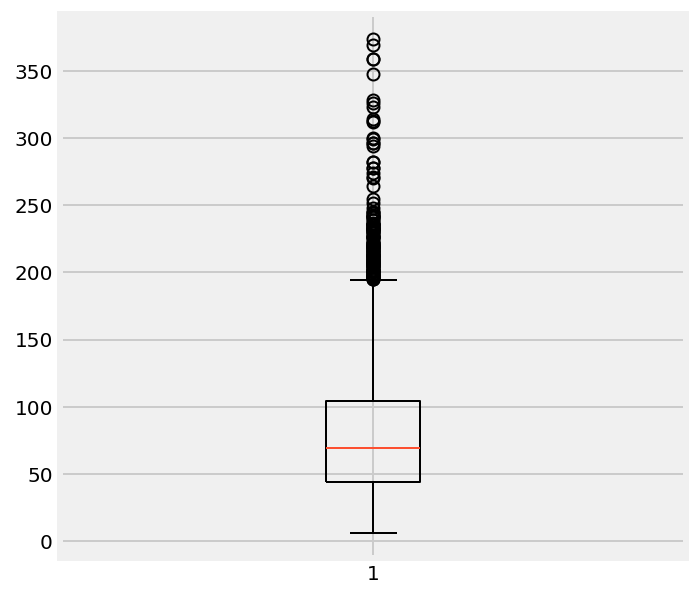

In [12]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.boxplot(df.toPandas()['pre_clean_len'])
plt.show()

## Data Preparation

In [13]:
df = df.select("*").withColumn("id", monotonically_increasing_id())
text_data = df.select('text').collect()

In [14]:
print(text_data[279]['text'])
example1 = BeautifulSoup(text_data[279]['text'], 'html.parser')
print(example1.get_text())

Whinging. My client&amp;boss don't understand English well. Rewrote some text unreadable. It's written by v. good writer&amp;reviewed correctly. 
Whinging. My client&boss don't understand English well. Rewrote some text unreadable. It's written by v. good writer&reviewed correctly. 


In [15]:
# Remove authoe
re.sub(r'@[A-Za-z0-9]+','',text_data[343]['text'])

' Not Fun &amp; Furious? The new mantra for the Bay 2 Breakers? It was getting 2 rambunctious;the city overreacted &amp; clamped down '

In [16]:
tok = WordPunctTokenizer()

In [17]:
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))

def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'html.parser')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()

In [18]:
%%time
nums = [0,400000,800000,1200000,1600000]
print("Cleaning and parsing the tweets...\n")
clean_tweet_texts = []
for i in range(nums[0],nums[1]):
    if( (i+1)%10000 == 0 ):
        print("Tweets %d of %d has been processed" % ( i+1, nums[1] ))                                                                    
    clean_tweet_texts.append(tweet_cleaner(text_data[i]['text']))

Cleaning and parsing the tweets...

Tweets 10000 of 400000 has been processed
Tweets 20000 of 400000 has been processed
Tweets 30000 of 400000 has been processed
Tweets 40000 of 400000 has been processed
Tweets 50000 of 400000 has been processed
Tweets 60000 of 400000 has been processed
Tweets 70000 of 400000 has been processed
Tweets 80000 of 400000 has been processed
Tweets 90000 of 400000 has been processed
Tweets 100000 of 400000 has been processed
Tweets 110000 of 400000 has been processed
Tweets 120000 of 400000 has been processed
Tweets 130000 of 400000 has been processed
Tweets 140000 of 400000 has been processed
Tweets 150000 of 400000 has been processed
Tweets 160000 of 400000 has been processed
Tweets 170000 of 400000 has been processed
Tweets 180000 of 400000 has been processed
Tweets 190000 of 400000 has been processed
Tweets 200000 of 400000 has been processed
Tweets 210000 of 400000 has been processed
Tweets 220000 of 400000 has been processed
Tweets 230000 of 400000 has

In [19]:
%%time
print("Cleaning and parsing the tweets...\n")
for i in range(nums[1],nums[2]):
    if( (i+1)%10000 == 0 ):
        print("Tweets %d of %d has been processed" % ( i+1, nums[2] )    )                                                                
    clean_tweet_texts.append(tweet_cleaner(text_data[i]['text']))

Cleaning and parsing the tweets...

Tweets 410000 of 800000 has been processed
Tweets 420000 of 800000 has been processed
Tweets 430000 of 800000 has been processed
Tweets 440000 of 800000 has been processed
Tweets 450000 of 800000 has been processed
Tweets 460000 of 800000 has been processed
Tweets 470000 of 800000 has been processed
Tweets 480000 of 800000 has been processed
Tweets 490000 of 800000 has been processed
Tweets 500000 of 800000 has been processed
Tweets 510000 of 800000 has been processed
Tweets 520000 of 800000 has been processed
Tweets 530000 of 800000 has been processed
Tweets 540000 of 800000 has been processed
Tweets 550000 of 800000 has been processed
Tweets 560000 of 800000 has been processed
Tweets 570000 of 800000 has been processed
Tweets 580000 of 800000 has been processed
Tweets 590000 of 800000 has been processed
Tweets 600000 of 800000 has been processed
Tweets 610000 of 800000 has been processed
Tweets 620000 of 800000 has been processed
Tweets 630000 of 8

In [20]:
%%time
print("Cleaning and parsing the tweets...\n")
for i in range(nums[2],nums[3]):
    if( (i+1)%10000 == 0 ):
        print("Tweets %d of %d has been processed" % ( i+1, nums[3] )    )                                                                
    clean_tweet_texts.append(tweet_cleaner(text_data[i]['text']))

Cleaning and parsing the tweets...

Tweets 810000 of 1200000 has been processed
Tweets 820000 of 1200000 has been processed
Tweets 830000 of 1200000 has been processed
Tweets 840000 of 1200000 has been processed
Tweets 850000 of 1200000 has been processed
Tweets 860000 of 1200000 has been processed
Tweets 870000 of 1200000 has been processed
Tweets 880000 of 1200000 has been processed
Tweets 890000 of 1200000 has been processed
Tweets 900000 of 1200000 has been processed
Tweets 910000 of 1200000 has been processed
Tweets 920000 of 1200000 has been processed
Tweets 930000 of 1200000 has been processed
Tweets 940000 of 1200000 has been processed
Tweets 950000 of 1200000 has been processed
Tweets 960000 of 1200000 has been processed
Tweets 970000 of 1200000 has been processed
Tweets 980000 of 1200000 has been processed
Tweets 990000 of 1200000 has been processed
Tweets 1000000 of 1200000 has been processed
Tweets 1010000 of 1200000 has been processed
Tweets 1020000 of 1200000 has been pro

In [21]:
%%time
print("Cleaning and parsing the tweets...\n")
for i in range(nums[3],nums[4]):
    if( (i+1)%10000 == 0 ):
        print("Tweets %d of %d has been processed" % ( i+1, nums[4] )    )                                                                
    clean_tweet_texts.append(tweet_cleaner(text_data[i]['text']))

Cleaning and parsing the tweets...

Tweets 1210000 of 1600000 has been processed
Tweets 1220000 of 1600000 has been processed
Tweets 1230000 of 1600000 has been processed
Tweets 1240000 of 1600000 has been processed
Tweets 1250000 of 1600000 has been processed
Tweets 1260000 of 1600000 has been processed
Tweets 1270000 of 1600000 has been processed
Tweets 1280000 of 1600000 has been processed
Tweets 1290000 of 1600000 has been processed
Tweets 1300000 of 1600000 has been processed
Tweets 1310000 of 1600000 has been processed
Tweets 1320000 of 1600000 has been processed
Tweets 1330000 of 1600000 has been processed
Tweets 1340000 of 1600000 has been processed
Tweets 1350000 of 1600000 has been processed
Tweets 1360000 of 1600000 has been processed
Tweets 1370000 of 1600000 has been processed
Tweets 1380000 of 1600000 has been processed
Tweets 1390000 of 1600000 has been processed
Tweets 1400000 of 1600000 has been processed
Tweets 1410000 of 1600000 has been processed
Tweets 1420000 of 1

In [22]:
len(clean_tweet_texts)

1600000

In [23]:
b = spark.createDataFrame([(l,) for l in clean_tweet_texts], ['clean_text'])
b = b.withColumn("id", monotonically_increasing_id())

In [24]:
final_df = df.drop("text").join(b, df.id == b.id).drop("id", "pre_clean_len")
#reduce(lambda data, id: data.withColumnRenamed(oldColumns[id], newColumns[id]), range(len(oldColumns)), data)
final_df.show()

+---------+--------------------+
|sentiment|          clean_text|
+---------+--------------------+
|        0|just going to cry...|
|        0|meh almost lover ...|
|        0|cant see the flow...|
|        0|im boredd gah i w...|
|        0|i am strongly con...|
|        0|got to do spanish...|
|        0|ahh ai dreptate p...|
|        0|its sprained so g...|
|        0|i think that it s...|
|        0|i guess graphic a...|
|        0|i think i should ...|
|        0|ouch zoom and the...|
|        0|i m still sad ove...|
|        0|going to walk my ...|
|        0|i really wish i w...|
|        0|im awake people g...|
|        0|yeah off aberdeen...|
|        0|suffice to say th...|
|        0|off to kl tomorro...|
|        0|too much booze ta...|
+---------+--------------------+
only showing top 20 rows



In [25]:
final_df.toPandas().to_csv("./data/clean_tweets.csv", header=True)

In [26]:
cols = ["index","target","text"]
my_df = spark.read.format('csv').options(header='true').load('./data/clean_tweets.csv').toDF(*cols)
my_df.show()
old_count = my_df.count()

+-----+------+--------------------+
|index|target|                text|
+-----+------+--------------------+
|    0|     0|just going to cry...|
|    1|     0|meh almost lover ...|
|    2|     0|cant see the flow...|
|    3|     0|im boredd gah i w...|
|    4|     0|i am strongly con...|
|    5|     0|got to do spanish...|
|    6|     0|ahh ai dreptate p...|
|    7|     0|its sprained so g...|
|    8|     0|i think that it s...|
|    9|     0|i guess graphic a...|
|   10|     0|i think i should ...|
|   11|     0|ouch zoom and the...|
|   12|     0|i m still sad ove...|
|   13|     0|going to walk my ...|
|   14|     0|i really wish i w...|
|   15|     0|im awake people g...|
|   16|     0|yeah off aberdeen...|
|   17|     0|suffice to say th...|
|   18|     0|off to kl tomorro...|
|   19|     0|too much booze ta...|
+-----+------+--------------------+
only showing top 20 rows



In [27]:
my_df = my_df.dropna()
print(str(abs(my_df.count() - old_count))+" éléments retirés")
print(type(my_df))

3214 éléments retirés
<class 'pyspark.sql.dataframe.DataFrame'>


In [28]:
neg_tweets = my_df[my_df.target == 0]
neg_tweets = neg_tweets.select('text').collect()

neg_string = []

for t in neg_tweets:
    neg_string.append(t['text'])
neg_string = pd.Series(str(neg_string)).str.cat(sep=' ')

pos_tweets = my_df[my_df.target == 1]
pos_tweets = pos_tweets.select('text').collect()
pos_string = []

for t in pos_tweets:
    pos_string.append(t['text'])
pos_string = pd.Series(str(pos_string)).str.cat(sep=' ')


Termes les plus courants dans les tweets négatifs


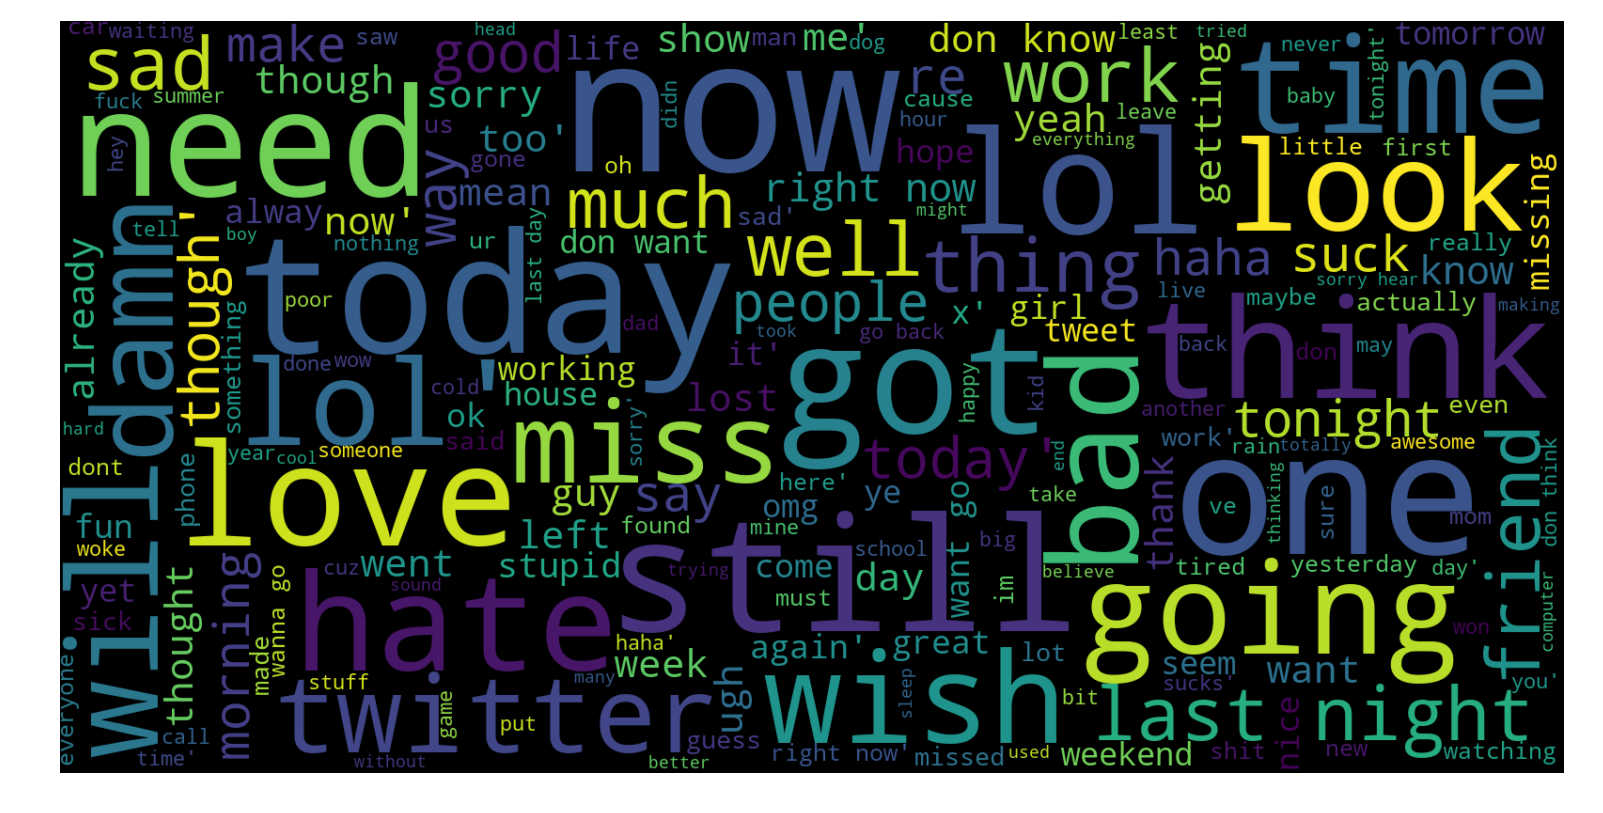

In [29]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
print("Termes les plus courants dans les tweets négatifs")
plt.show()

Termes les + courants dans les tweets positifs


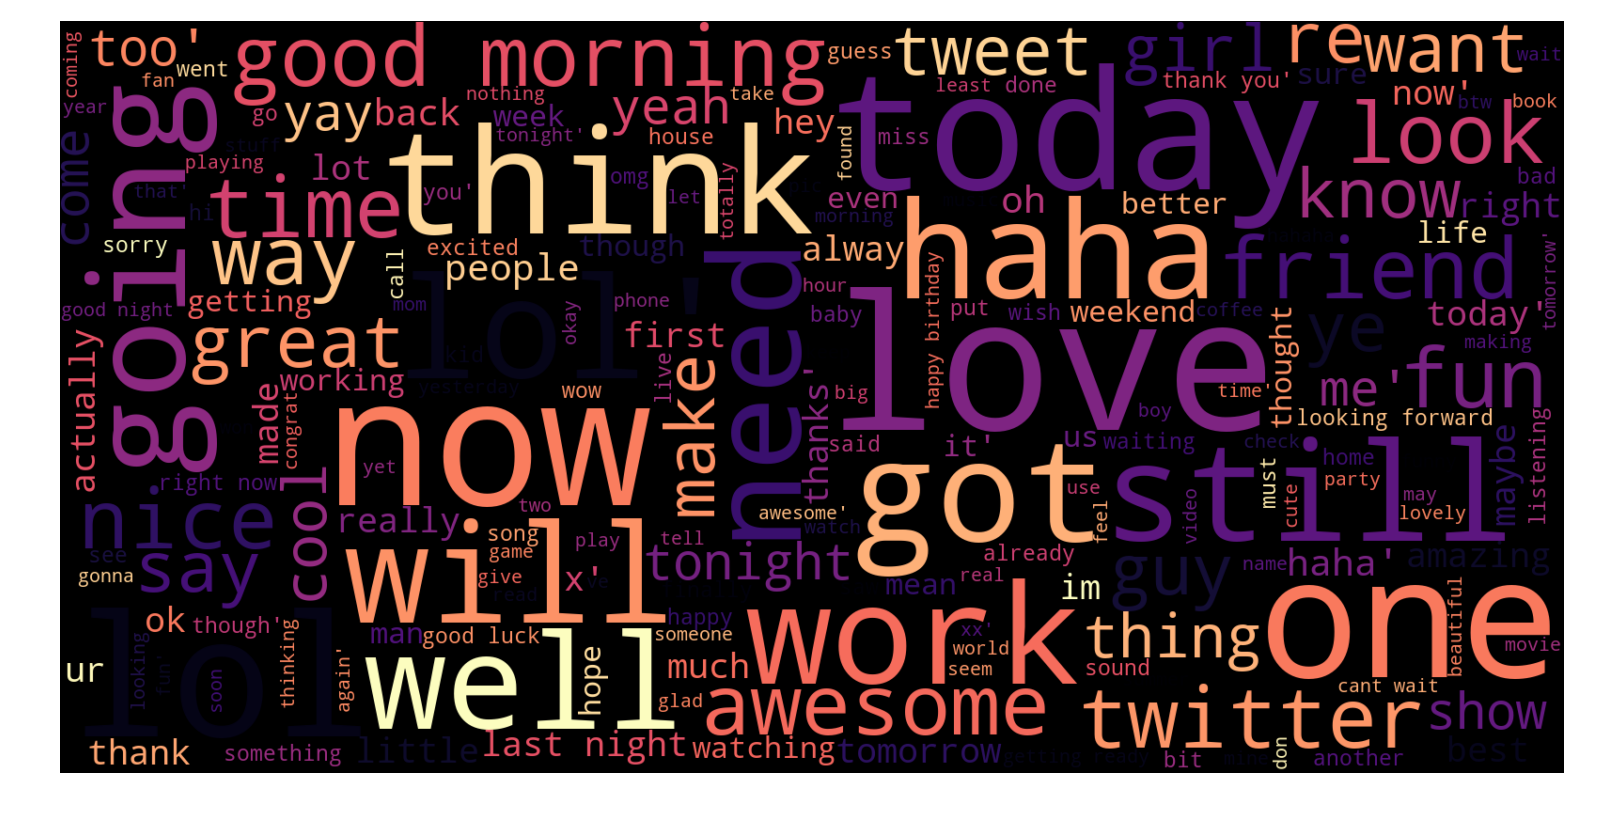

In [30]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(pos_string)
plt.figure(figsize=(12,10))
print('Termes les + courants dans les tweets positifs')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [31]:
from pyspark.sql.functions import split, regexp_replace
my_df.printSchema()

my_df = my_df.withColumn(
    "text",
    split(regexp_replace("text", r"(^\[\[\[)|(\]\]\]$)", ""), ", ")
)
my_df.printSchema()

root
 |-- index: string (nullable = true)
 |-- target: string (nullable = true)
 |-- text: string (nullable = true)

root
 |-- index: string (nullable = true)
 |-- target: string (nullable = true)
 |-- text: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [36]:
cvec = CountVectorizer(inputCol="text", outputCol="features", vocabSize=6000, minDF=15.0)
cvec.fit(my_df)

CountVectorizer_df1cba28e6b4

In [71]:
cols=['id', 'target', 'text']


df = spark.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('./data/clean_tweets.csv').toDF(*cols)
df = df.dropna()
(train_set, val_set, test_set) = df.randomSplit([0.98, 0.01, 0.01], seed = 2000)


In [69]:
df.count()

1574125

## HashingTF + IDF + Logistic Regression


In [73]:
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashtf = HashingTF(numFeatures=2**16, inputCol="words", outputCol='tf')
idf = IDF(inputCol='tf', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")
pipeline = Pipeline(stages=[tokenizer, hashtf, idf, label_stringIdx])

pipelineFit = pipeline.fit(train_set)
train_df = pipelineFit.transform(train_set)
val_df = pipelineFit.transform(val_set)
train_df.show(5)

+---+------+--------------------+--------------------+--------------------+--------------------+-----+
| id|target|                text|               words|                  tf|            features|label|
+---+------+--------------------+--------------------+--------------------+--------------------+-----+
|  0|     0|just going to cry...|[just, going, to,...|(65536,[8436,2443...|(65536,[8436,2443...|  0.0|
|  1|     0|meh almost lover ...|[meh, almost, lov...|(65536,[11604,158...|(65536,[11604,158...|  0.0|
|  2|     0|cant see the flow...|[cant, see, the, ...|(65536,[1669,1739...|(65536,[1669,1739...|  0.0|
|  3|     0|im boredd gah i w...|[im, boredd, gah,...|(65536,[3585,1669...|(65536,[3585,1669...|  0.0|
|  4|     0|i am strongly con...|[i, am, strongly,...|(65536,[723,5381,...|(65536,[723,5381,...|  0.0|
+---+------+--------------------+--------------------+--------------------+--------------------+-----+
only showing top 5 rows



In [74]:
lr = LogisticRegression(maxIter=100)
lrModel = lr.fit(train_df)
predictions = lrModel.transform(val_df)

In [75]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(predictions)

0.8550656528470766

In [76]:
evaluator.getMetricName()

'areaUnderROC'

In [77]:
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(val_set.count())
accuracy

0.7895549266786726

## CountVectorizer + IDF + Logistic Regression

In [84]:
%%time

tokenizer = Tokenizer(inputCol="text", outputCol="words")
cv = CountVectorizer(vocabSize=2**16, inputCol="words", outputCol='cv')
idf = IDF(inputCol='cv', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")
lr = LogisticRegression(maxIter=100)
pipeline = Pipeline(stages=[tokenizer, cv, idf, label_stringIdx, lr])

pipelineFit = pipeline.fit(train_set)
predictions = pipelineFit.transform(val_set)
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(val_set.count())
roc_auc = evaluator.evaluate(predictions)

print("Accuracy Score: "+str(accuracy))
print("ROC-AUC: "+str(roc_auc))

Accuracy Score: 0.7948289169024955
ROC-AUC: 0.8606349193111538
CPU times: user 80.7 ms, sys: 14.7 ms, total: 95.5 ms
Wall time: 1min 2s


## N-gram Implementation


In [85]:
def build_trigrams(inputCol=["text","target"], n=3):
    tokenizer = [Tokenizer(inputCol="text", outputCol="words")]
    ngrams = [
        NGram(n=i, inputCol="words", outputCol="{0}_grams".format(i))
        for i in range(1, n + 1)
    ]

    cv = [
        CountVectorizer(vocabSize=2**14,inputCol="{0}_grams".format(i),
            outputCol="{0}_tf".format(i))
        for i in range(1, n + 1)
    ]
    idf = [IDF(inputCol="{0}_tf".format(i), outputCol="{0}_tfidf".format(i), minDocFreq=5) for i in range(1, n + 1)]

    assembler = [VectorAssembler(
        inputCols=["{0}_tfidf".format(i) for i in range(1, n + 1)],
        outputCol="rawFeatures"
    )]
    label_stringIdx = [StringIndexer(inputCol = "target", outputCol = "label")]
    selector = [ChiSqSelector(numTopFeatures=2**14,featuresCol='rawFeatures', outputCol="features")]
    lr = [LogisticRegression(maxIter=100)]
    return Pipeline(stages=tokenizer + ngrams + cv + idf+ assembler + label_stringIdx+selector+lr)

In [ ]:
%%time

trigram_pipelineFit = build_trigrams().fit(train_set)
predictions = trigram_pipelineFit.transform(val_set)

In [90]:
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(test_set.count())
roc_auc = evaluator.evaluate(predictions)

# print accuracy, roc_auc
print("Accuracy Score: "+str(accuracy))
print("ROC-AUC: "+str(roc_auc))

Accuracy Score: 0.7924361802710369
ROC-AUC: 0.8821083928895763


In [91]:
def build_ngrams_wocs(inputCol=["text","target"], n=3):
    tokenizer = [Tokenizer(inputCol="text", outputCol="words")]
    ngrams = [
        NGram(n=i, inputCol="words", outputCol="{0}_grams".format(i))
        for i in range(1, n + 1)
    ]

    cv = [
        CountVectorizer(vocabSize=5460,inputCol="{0}_grams".format(i),
            outputCol="{0}_tf".format(i))
        for i in range(1, n + 1)
    ]
    idf = [IDF(inputCol="{0}_tf".format(i), outputCol="{0}_tfidf".format(i), minDocFreq=5) for i in range(1, n + 1)]

    assembler = [VectorAssembler(
        inputCols=["{0}_tfidf".format(i) for i in range(1, n + 1)],
        outputCol="features"
    )]
    label_stringIdx = [StringIndexer(inputCol = "target", outputCol = "label")]
    lr = [LogisticRegression(maxIter=100)]
    return Pipeline(stages=tokenizer + ngrams + cv + idf+ assembler + label_stringIdx+lr)

In [92]:
%%time

trigramwocs_pipelineFit = build_ngrams_wocs().fit(train_set)
predictions_wocs = trigramwocs_pipelineFit.transform(val_set)
accuracy_wocs = predictions_wocs.filter(predictions_wocs.label == predictions_wocs.prediction).count() / float(val_set.count())
roc_auc_wocs = evaluator.evaluate(predictions_wocs)

# print accuracy, roc_auc
print("Accuracy Score: "+str(accuracy_wocs))
print("ROC-AUC: " +str(roc_auc_wocs))

Accuracy Score: 0.8066632364291227
ROC-AUC: 0.8790895440472608
CPU times: user 223 ms, sys: 28.8 ms, total: 251 ms
Wall time: 3min 14s


In [93]:
test_predictions = trigramwocs_pipelineFit.transform(test_set)
test_accuracy = test_predictions.filter(test_predictions.label == test_predictions.prediction).count() / float(test_set.count())
test_roc_auc = evaluator.evaluate(test_predictions)

# print accuracy, roc_auc
print("Accuracy Score: "+str(test_accuracy))
print("ROC-AUC: "+str(test_roc_auc))

Accuracy Score: 0.805735896627797
ROC-AUC: 0.8791621337508075
